# Answers

In [1]:
# general imports for ode integration
import numpy as np
import pandas as pd
import roadrunner
from matplotlib import pylab as plt
from pprint import pprint
from helpers import *

# global settings for plots (optional)
plt.rcParams.update({
        'axes.labelsize': 'large', 
        'axes.labelweight': 'bold',
        'axes.titlesize': 'large',
        'axes.titleweight': 'bold',
        'legend.fontsize': 'small',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
    })

# load model and set selections
r = roadrunner.RoadRunner(caffeine_model)
r.timeCourseSelections = ["time"] + r.model.getFloatingSpeciesIds() + r.model.getGlobalParameterIds()

## E1 Your caffeine level
The first exercise is to calculate the timecourse of the expected venous caffeine level after you drink some caffeinated beverage. To estimate your oral dose of caffeine you can estimate the caffeine content from the following chart

![Fig.2 Caffeine Content of Beverages](figures/caffeine_levels.jpg)

The oral dose is defined in the model via parameter `r['init(PODOSE_caf)'] = 100` [mg]. In addition you can also adjust the bodyweight to get a more realistic estimation via the parameter `r['init(BW)']= 70` [kg].

* What would be your level of caffeine now, if you had two cups of coffee for breakfast this morning?
* How would your time course and level of caffeine look if you would take the same amount of caffeine intravenously (I.V)? (Hint: you have to set the set the i.v. dose via `r['init(IVDOSE_caf)'] = 100`)
* What is the peak time of caffeine in venous blood? What is the peak concentration?

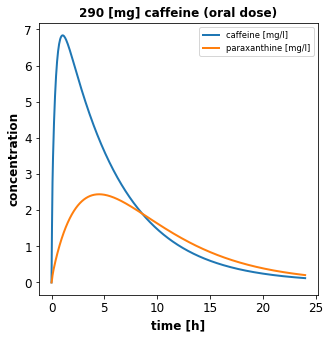

In [2]:
# reset model
r.reset(roadrunner.SelectionRecord.ALL)

# drinking a monster energy drink
dose = 290 # [mg]
r['init(PODOSE_caf)'] = dose  # [mg]
r['init(BW)'] = 55  # [kg]

# simulate the model for 24[h]
s = simulate(r, start=0, end=24, steps=500)

# plot venous caffeine & paraxanthine against time
f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(s.time, s.Cve_caf, linewidth=2, label="caffeine [mg/l]")
ax1.plot(s.time, s.Cve_px, linewidth=2, label="paraxanthine [mg/l]")
ax1.set_title('{} [mg] caffeine (oral dose)'.format(dose))
ax1.set_ylabel('concentration')
ax1.set_xlabel('time [h]')
ax1.legend()
plt.show()

# find the maximal values
# print("Max caffeine [mg/l]:", s.Cve_caf.max())
# print("Max time [h]:", s.time[s.Cve_caf.idxmax()])

In [3]:
# find the maximal values (using pandas Series)
print("Max caffeine [mg/l]:", s.Cve_caf.max())
print("Max time [h]:", s.time[s.Cve_caf.idxmax()])

Max caffeine [mg/l]: 6.837980670855121
Max time [h]: 1.056


In [4]:
# find pharmacokinetic parameter using numpy array
caf_vec = s.Cve_caf.values
time_vec = s.time.values

In [5]:
caf_max = np.amax(caf_vec)
np.where(caf_vec == caf_max)
time_vec[22]

1.056

[  5.          26.07142857  47.14285714  68.21428571  89.28571429
 110.35714286 131.42857143 152.5        173.57142857 194.64285714
 215.71428571 236.78571429 257.85714286 278.92857143 300.        ]


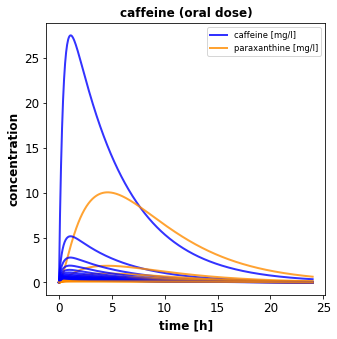

In [6]:
# dosing per bodyweight
bodyweights = np.linspace(5, 300, num=15)
print(bodyweights)
results = []

for bodyweight in bodyweights:
    # reset model to initial state
    r.reset(roadrunner.SelectionRecord.ALL)
    
    # set the bodyweight
    r['init(PODOSE_caf)'] = 100 # [mg]
    r['init(BW)'] = bodyweight  # [kg]

    # simulate the model for 24[h]
    s = simulate(r, start=0, end=24, steps=500)
    results.append(s)

# plot venous caffeine & paraxanthine against time
f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
for k, s in enumerate(results):
    if k == 1:
        label = "caffeine [mg/l]"
    else:
        label = "__nolabel__"
    ax1.plot(s.time, s.Cve_caf, linewidth=2, color="blue", label=label, alpha=0.8)
    if k == 1:
        label = "paraxanthine [mg/l]"
    else:
        label = "__nolabel__"
    ax1.plot(s.time, s.Cve_px, linewidth=2, color="darkorange", label=label, alpha=0.8)
ax1.set_title('caffeine (oral dose)')
ax1.set_ylabel('concentration')
ax1.set_xlabel('time [h]')
ax1.legend()
plt.show()

No handles with labels found to put in legend.


[  5.          26.07142857  47.14285714  68.21428571  89.28571429
 110.35714286 131.42857143 152.5        173.57142857 194.64285714
 215.71428571 236.78571429 257.85714286 278.92857143 300.        ]
[27.51107496859273, 5.140813419591984, 2.7747178440085833, 1.8746758305664522, 1.4032627526367294, 1.1151645604029938, 0.9231815865280283, 0.7887160477659401, 0.6933179908077778, 0.6247940822449736, 0.5721776371541409, 0.5293520641837476, 0.4931129220632062, 0.46182127203921736, 0.4343349729517605]


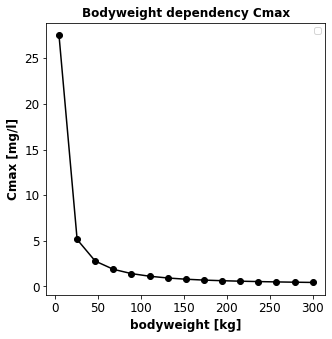

In [7]:
# plot maximal concentration vs. bodyweight
cmax_values = []
for s in results:
    cmax = s.Cve_caf.max()
    cmax_values.append(cmax)

print(bodyweights)
print(cmax_values)

f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(bodyweights, cmax_values, '-o', color="black")
ax1.set_title('Bodyweight dependency Cmax')
ax1.set_ylabel('Cmax [mg/l]')
ax1.set_xlabel('bodyweight [kg]')
ax1.legend()
plt.show()

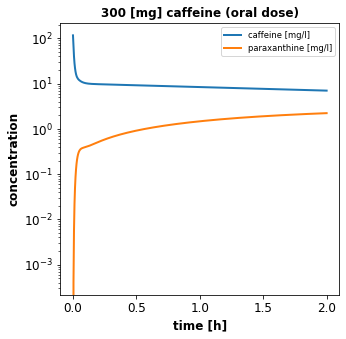

Max caffeine [mg/l]: 116.73151750972761
Max time [hr]: 0.0


In [8]:
# intravenous dosing
# reset model
r.reset(roadrunner.SelectionRecord.ALL)

# drinking a monster energy drink
dose = 300  # [mg]
r['init(IVDOSE_caf)'] = dose  # [mg]
r['init(BW)'] = 50

# simulate the model for 24[h]
s = simulate(r, start=0, end=2, steps=500)

# plot venous caffeine & paraxanthine against time
f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
ax1.plot(s.time, s.Cve_caf, linewidth=2, label="caffeine [mg/l]")
ax1.plot(s.time, s.Cve_px, linewidth=2, label="paraxanthine [mg/l]")
ax1.set_title('{} [mg] caffeine (oral dose)'.format(dose))
ax1.set_ylabel('concentration')
ax1.set_xlabel('time [h]')
ax1.set_yscale("log")
ax1.legend()
plt.show()

# find the maximal values
print("Max caffeine [mg/l]:", s.Cve_caf.max())
print("Max time [hr]:", s.time[s.Cve_caf.idxmax()])

## E2 Interindividual variability
We saw that there is a large variability in caffeine kinetics in the population. Depending on if you are a fast or slow metabolizer of caffeine the timecourses can look very different. In E1 you calculated the mean timecourse for the population. Now we will look at the interindividual differences.

Your caffeine clearance by the liver depends on the activity of CYP1A2 in the liver, the main enzyme metabolizing caffeine. The activity is defined via the apparent clearance caffeine by hepatic microsomes (`r[init('HLM_CLint_caf')] = 2` [mul/min/mg]).

* How would your time course / level of caffeine change if you are a slow metabolizer (small apparent clearance), or if you are a fast metabolizer (large apperent clearance)?
* Simulate the effect of lifestyle changes on your caffeine clearance via adjusting the caffeine clearance accordinly. For instance simulate changes in your coffee intake or smoking habit. An overview over the changes in apparent clearance are given in Tab.1. 
* How would your caffeine timecourse change if you smoke >20 cigarettes per day and drink 1 liter of coffee (the effects are additive) compared to being abstinent?

![Tab.1 Lifestyle Effects](figures/Tantcheva-Poor1999_Tab4.png)

Traceback (most recent call last):
  File "<ipython-input-9-f6a6dc12cdbb>", line 5, in <module>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Traceback (most recent call last):
  File "<ipython-input-9-f6a6dc12cdbb>", line 5, in <module>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Traceback (most recent call last):
  File "<ipython-input-9-f6a6dc12cdbb>"

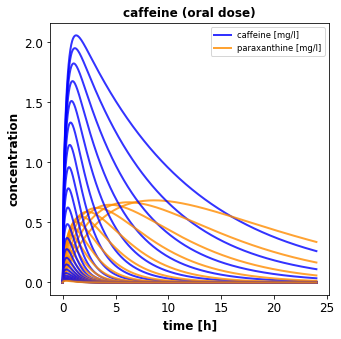

In [9]:
# changes in clearance
# cyp1a2_values = np.linspace(0, 10, num=11)
cyp1a2_values = np.logspace(1e-10, 3, num=21)

results = []

for cyp1a2 in cyp1a2_values:
    # reset model to initial state
    r.reset(roadrunner.SelectionRecord.ALL)
    
    # set the CYP1A2
    r['init(PODOSE_caf)'] = 100  # [mg]
    r['init(HLM_CLint_caf)'] = cyp1a2 # [mg]

    # simulate the model for 24[h]
    s = simulate(r, start=0, end=24, steps=2000)
    results.append(s)

# plot venous caffeine & paraxanthine against time
f1, ax1 = plt.subplots(1, 1, figsize=(5, 5))
for k, s in enumerate(results):
    if k == 1:
        label = "caffeine [mg/l]"
    else:
        label = "__nolabel__"
    ax1.plot(s.time, s.Cve_caf, linewidth=2, color="blue", label=label, alpha=0.8)
    if k == 1:
        label = "paraxanthine [mg/l]"
    else:
        label = "__nolabel__"
    ax1.plot(s.time, s.Cve_px, linewidth=2, color="darkorange", label=label, alpha=0.8)
ax1.set_title('caffeine (oral dose)')
ax1.set_ylabel('concentration')
ax1.set_xlabel('time [h]')
ax1.legend()
plt.show()

[   1.            1.41253754    1.99526232    2.81838293    3.98107171
    5.62341325    7.94328235   11.22018454   15.84893193   22.38721139
   31.62277661   44.66835922   63.09573445   89.12509382  125.89254119
  177.82794101  251.18864316  354.81338925  501.18723364  707.94578439
 1000.        ]
[2.058532592195602, 1.9517862421909533, 1.824616036259966, 1.6771555446310238, 1.511568936187568, 1.3322634481485944, 1.1458596135847356, 0.9604204934533158, 0.7842638019488856, 0.6244846849046652, 0.4858315646928778, 0.37030659865586935, 0.27742427927966384, 0.2049373762600911, 0.14973601629551675, 0.10848392803839202, 0.07810431312068673, 0.055962382460136066, 0.03996611685298112, 0.028470059926139185, 0.020244240863896854]
[1.26, 1.1520000000000001, 1.032, 0.924, 0.8280000000000001, 0.744, 0.66, 0.588, 0.528, 0.48, 0.444, 0.40800000000000003, 0.384, 0.372, 0.34800000000000003, 0.34800000000000003, 0.336, 0.336, 0.324, 0.324, 0.324]


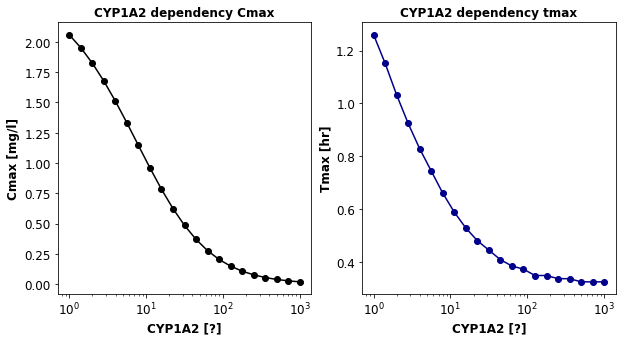

In [10]:
# plot maximal concentration vs. bodyweight
cmax_values = []
tmax_values = []
for s in results:
    cmax = s.Cve_caf.max()
    cmax_values.append(cmax)
    tmax = s.time[s.Cve_caf.idxmax()]
    tmax_values.append(tmax)

print(cyp1a2_values)
print(cmax_values)
print(tmax_values)


f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(cyp1a2_values, cmax_values, '-o', color="black")
ax1.set_title('CYP1A2 dependency Cmax')
ax1.set_ylabel('Cmax [mg/l]')
ax1.set_xlabel('CYP1A2 [?]')
ax2.plot(cyp1a2_values, tmax_values, '-o', color="darkblue")
ax2.set_title('CYP1A2 dependency tmax')
ax2.set_ylabel('Tmax [hr]')
ax2.set_xlabel('CYP1A2 [?]')

for ax in (ax1, ax2):
    ax.set_xscale("log")
plt.show()